In [7]:
# Install required packages
!pip install captum

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import precision_recall_curve
import numpy as np

# Define device for training (MPS for Mac M1/M2, GPU if available, otherwise CPU)
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Define a CNN model similar to the provided architecture
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()
        
        # First convolutional block
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Second convolutional block
        self.conv2 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Third convolutional block
        self.conv3 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Fourth convolutional block
        self.conv4 = nn.Sequential(
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Fifth convolutional block
        self.conv5 = nn.Sequential(
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding='same'),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.BatchNorm2d(256),
            nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        )
        
        # Flatten layer
        self.flatten = nn.Flatten()
        
        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Linear(256 * 7 * 7, 128),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(128, 1)
        )
        
    def forward(self, x):
        # Apply convolutional blocks
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.conv5(x)
        
        # Handle MPS device issue with adaptive pooling by moving to CPU if needed
        if x.device.type == 'mps':
            # Move to CPU, apply operations, then move back to MPS
            x_cpu = x.to('cpu')
            x_cpu = self.flatten(x_cpu)
            x = x_cpu.to(device)
        else:
            x = self.flatten(x)
            
        # Apply fully connected layers
        x = self.fc(x)
        return x

# Initialize the model
model = CNNModel()
model = model.to(device)
model.eval()

# Load your trained weights
model.load_state_dict(torch.load("pneumonia_cnn_model_15epochs.pth", map_location=device))

print("Model loaded and ready.")

Using device: mps
Model loaded and ready.


In [9]:
import torchvision.transforms as transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset
import os

def pad_to_square(image):
    """Pad the image to make it square with zeros around the border."""
    w, h = image.size
    max_dim = max(w, h)
    pad_w = (max_dim - w) // 2
    pad_h = (max_dim - h) // 2
    padding = (pad_w, pad_h, max_dim - w - pad_w, max_dim - h - pad_h)
    return transforms.functional.pad(image, padding, fill=0)

# Custom dataset class for chest X-ray images
class ChestXRayDataset(Dataset):
    def __init__(self, root_dir, class_dirs, transform=None):
        self.filepaths = []
        self.labels = []
        self.transform = transform
        
        # Define label mapping dictionary
        self.label_map = {'NORMAL': 0, 'PNEUMONIA': 1}
        
        # For each class directory, collect all image paths and assign labels
        for class_dir in class_dirs:
            class_path = os.path.join(root_dir, class_dir)
            files = [os.path.join(class_path, f) for f in os.listdir(class_path) if f.endswith(('.jpeg', '.jpg', '.png'))]
            self.filepaths.extend(files)
            self.labels.extend([self.label_map[class_dir]] * len(files))
        
    def __len__(self):
        return len(self.filepaths)
    
    def __getitem__(self, idx):
        img_path = self.filepaths[idx]
        image = Image.open(img_path)
        label = self.labels[idx]
        
        if self.transform:
            image = self.transform(image)
            
        return image, torch.tensor(label, dtype=torch.long)

# Define paths for datasets
data_dir = 'data'  # Adjust this to your data directory
train_dir = os.path.join(data_dir, 'train')
val_dir = os.path.join(data_dir, 'val')
test_dir = os.path.join(data_dir, 'test')

# Class directories
class_dirs = ['NORMAL', 'PNEUMONIA']

# Define mean and std values from the training set
mean = [0.34463736414909363, 0.34463736414909363, 0.34463736414909363]
std = [0.28305476903915405, 0.28305476903915405, 0.28305476903915405]

# Define the transform with normalization
transform = transforms.Compose([
    transforms.Lambda(pad_to_square),               # Pad to square
    transforms.Resize((224, 224)),                  # Resize to 224x224
    transforms.Grayscale(num_output_channels=3),    # Convert to 3 channels
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)        # Use training set normalization
])

# Create datasets with the transform
test_dataset = ChestXRayDataset(
    root_dir=test_dir,
    class_dirs=class_dirs,
    transform=transform
)

# Create data loader
test_loader = torch.utils.data.DataLoader(
    test_dataset, 
    batch_size=32,
    shuffle=False
)

print(f"Test dataset size: {len(test_dataset)}")



Test dataset size: 624


In [10]:
# Collect 5 NORMAL and 5 PNEUMONIA images
normal_samples = []
pneumonia_samples = []
normal_indices = []
pneumonia_indices = []

for idx, (img, label) in enumerate(test_dataset):
    if label.item() == 0 and len(normal_samples) < 5:
        normal_samples.append((img, label))
        normal_indices.append(idx)
    elif label.item() == 1 and len(pneumonia_samples) < 5:
        pneumonia_samples.append((img, label))
        pneumonia_indices.append(idx)
    if len(normal_samples) == 5 and len(pneumonia_samples) == 5:
        break

selected_samples = normal_samples + pneumonia_samples
selected_indices = normal_indices + pneumonia_indices
print(f"Selected {len(selected_samples)} samples (5 normal + 5 pneumonia).")
print(f"Normal indices: {normal_indices}")
print(f"Pneumonia indices: {pneumonia_indices}")

Selected 10 samples (5 normal + 5 pneumonia).
Normal indices: [0, 1, 2, 3, 4]
Pneumonia indices: [234, 235, 236, 237, 238]


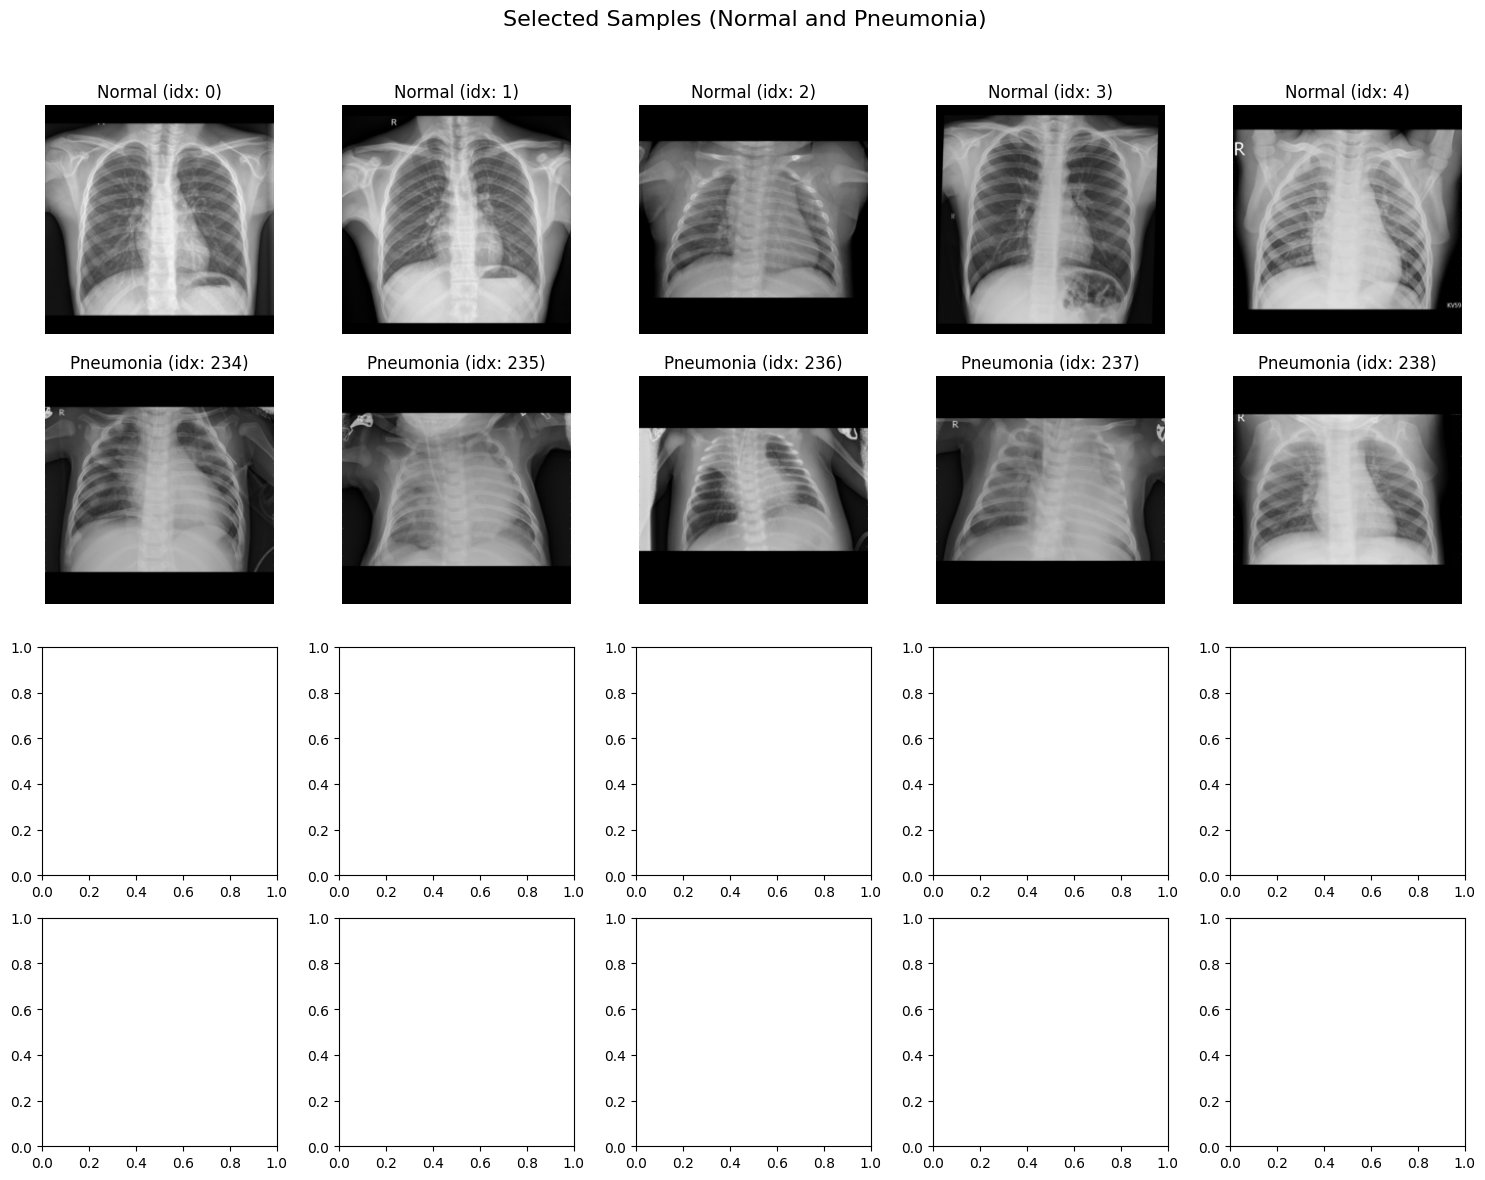

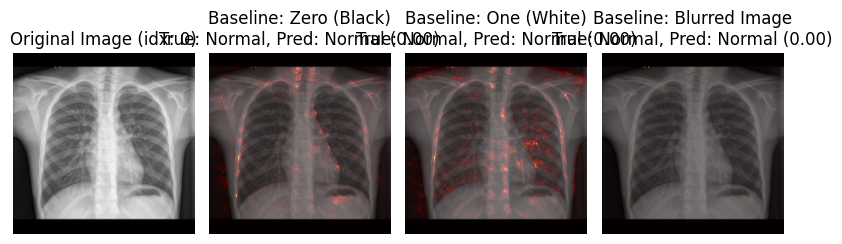

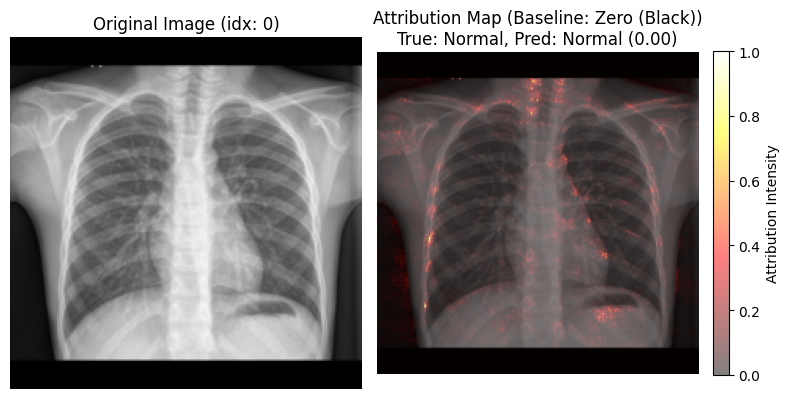

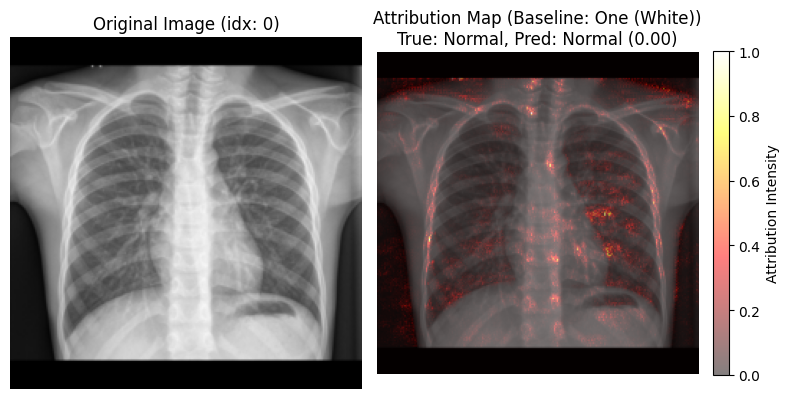

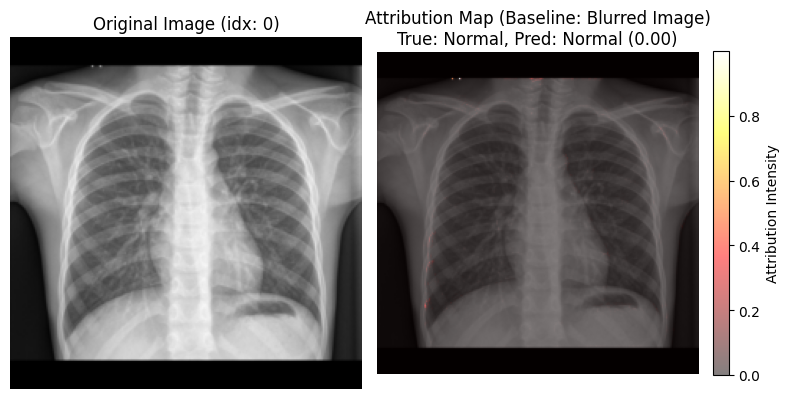

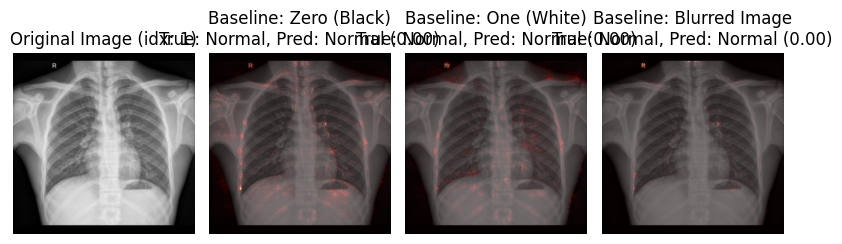

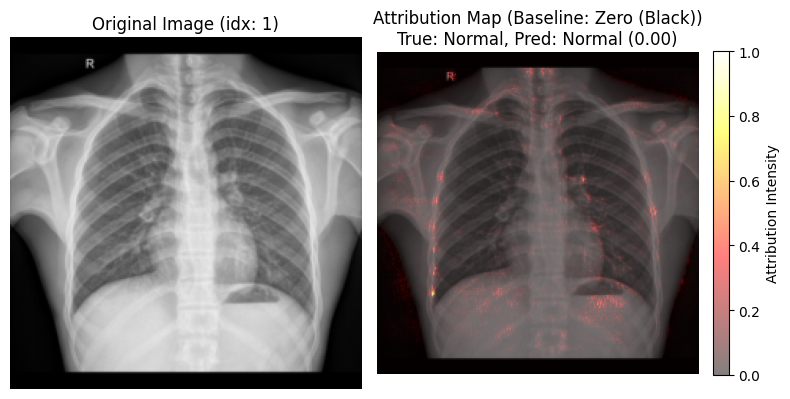

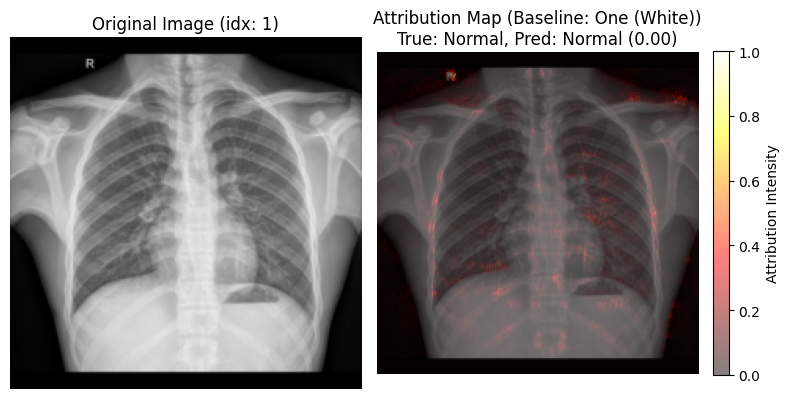

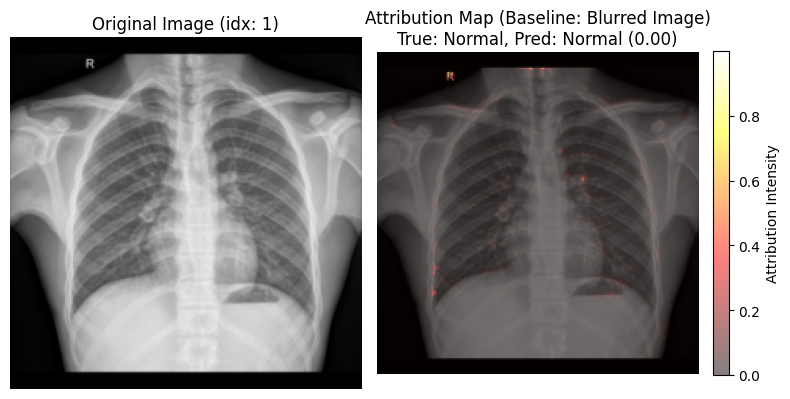

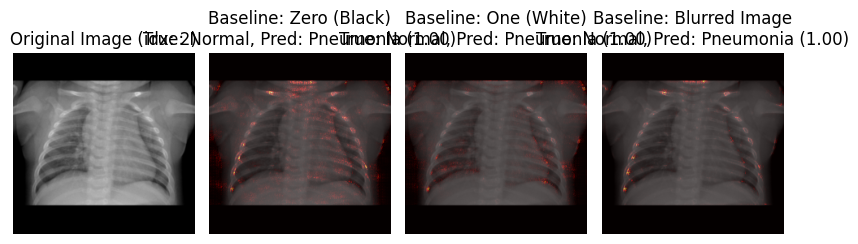

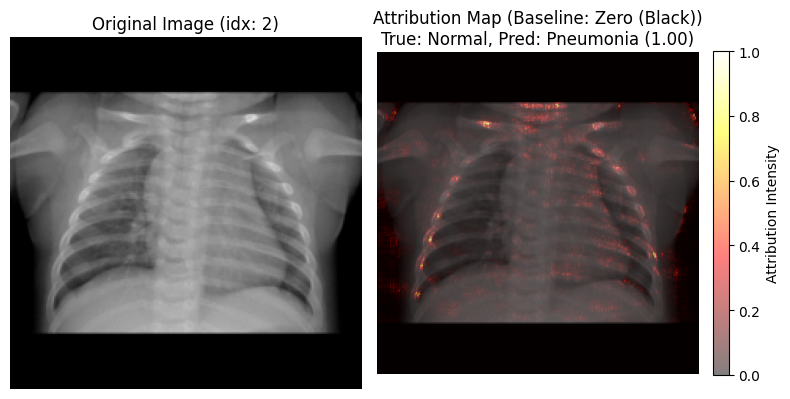

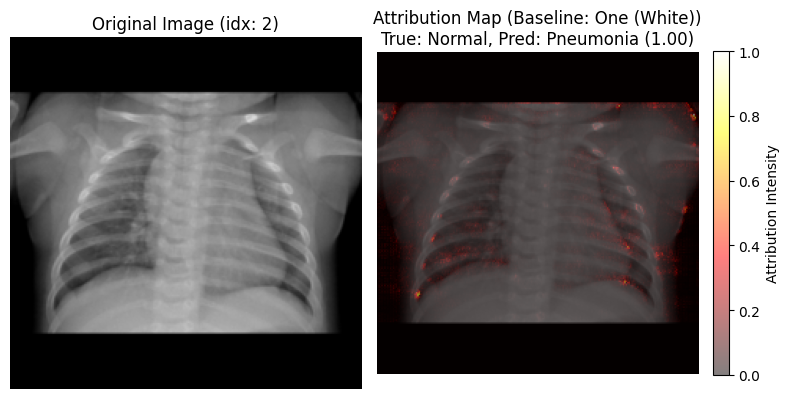

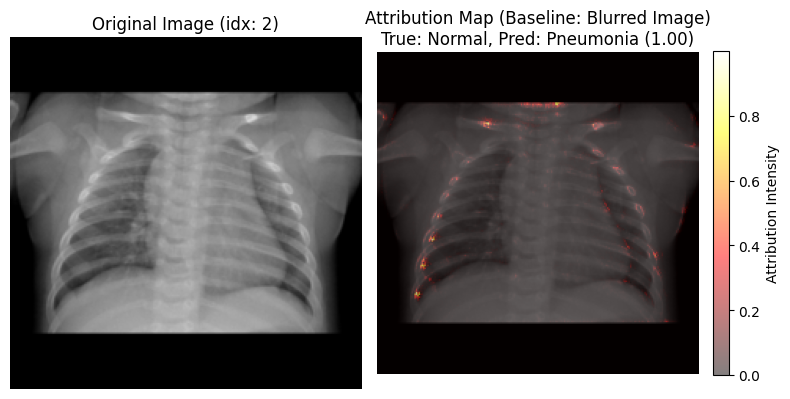

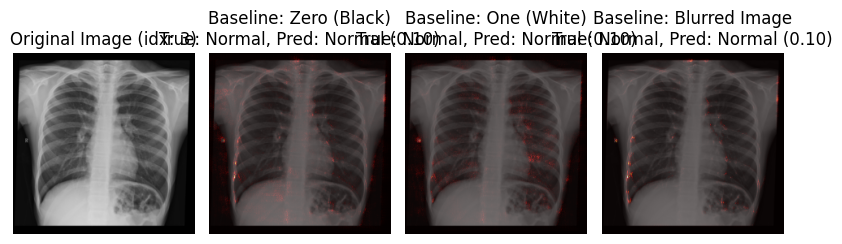

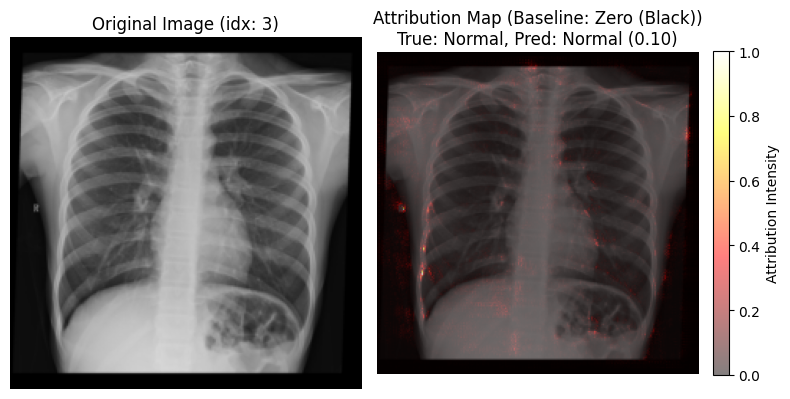

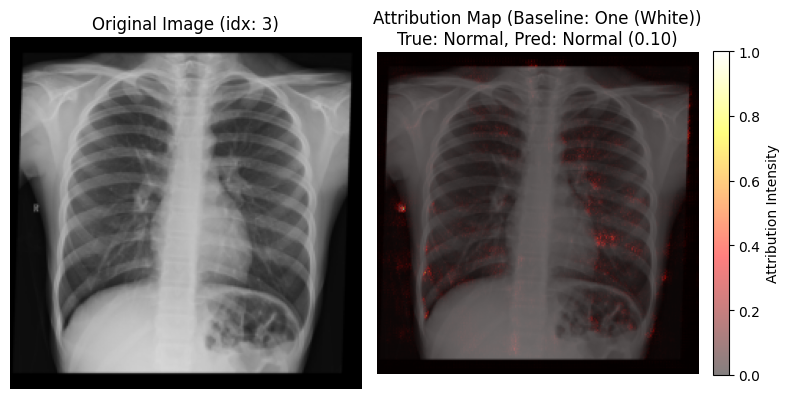

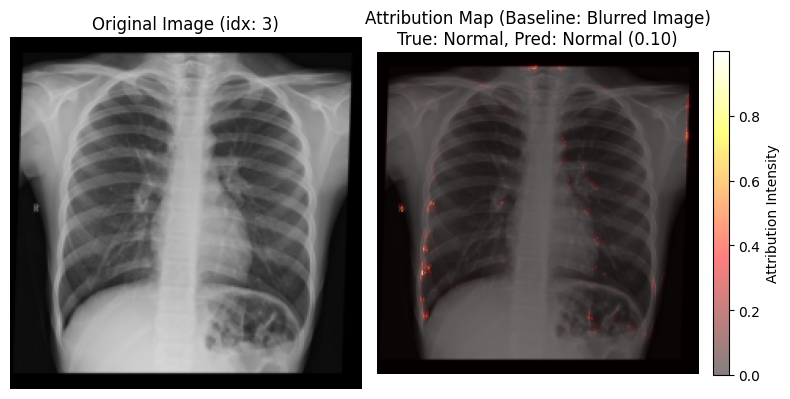

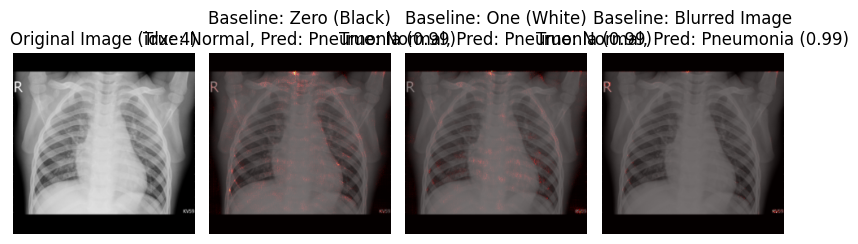

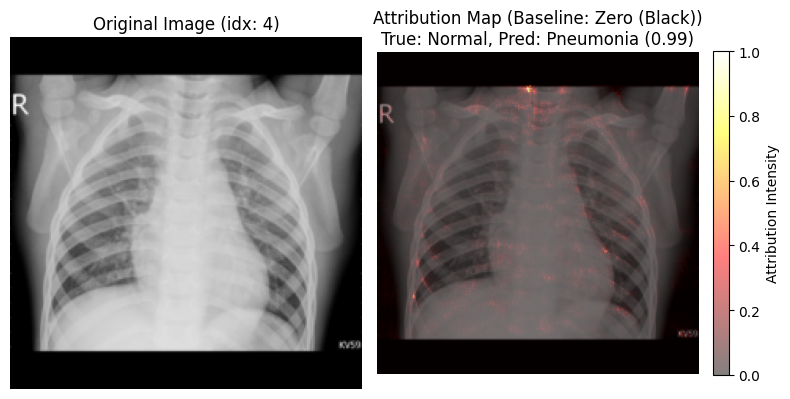

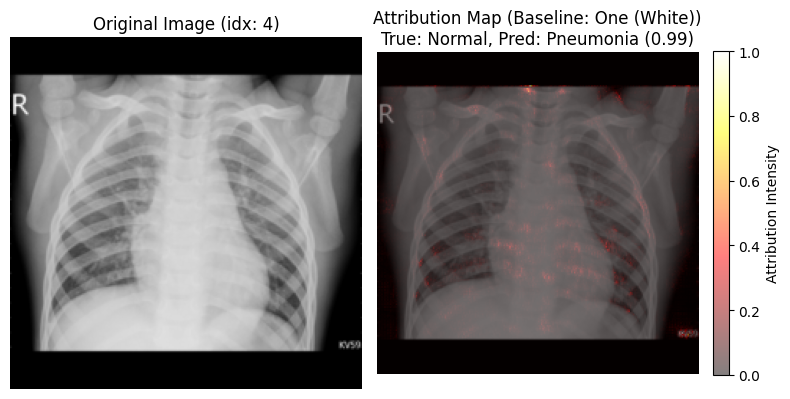

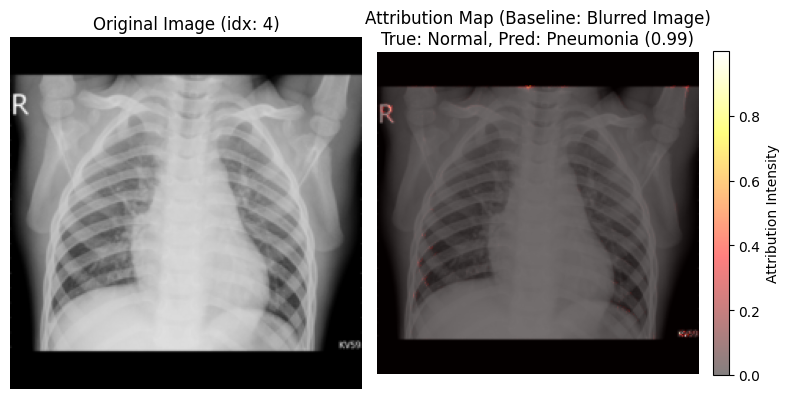

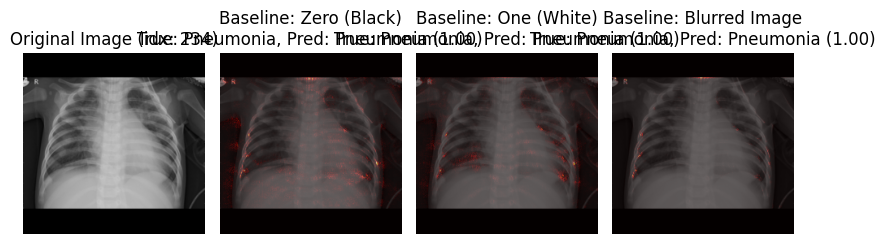

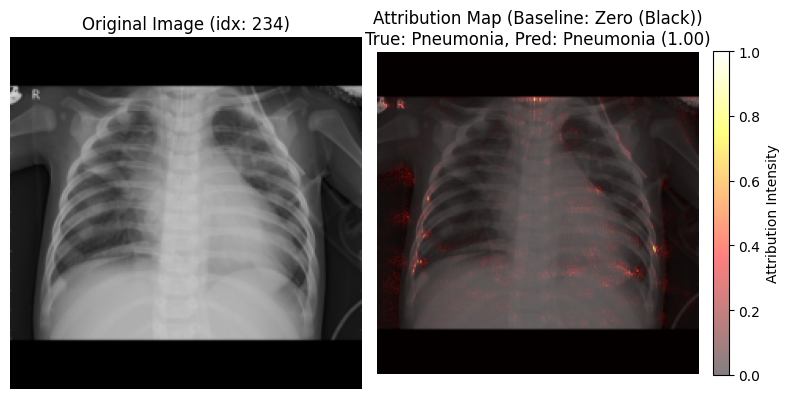

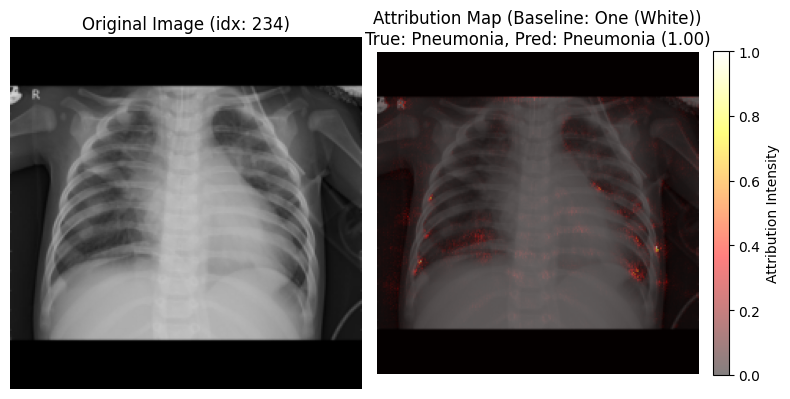

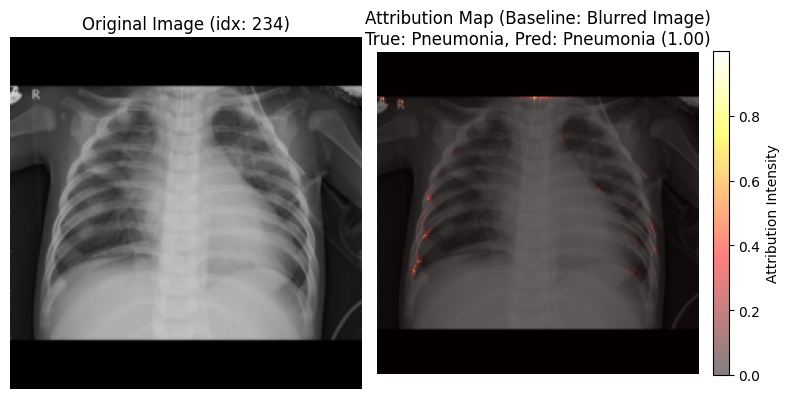

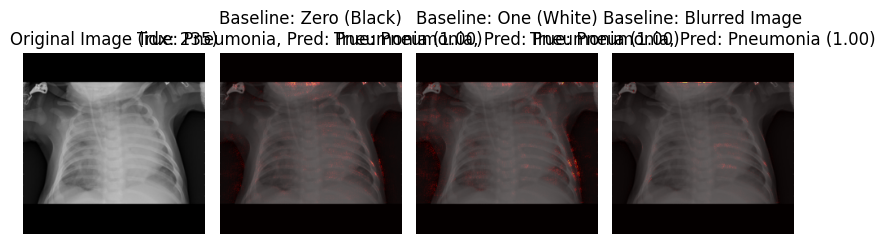

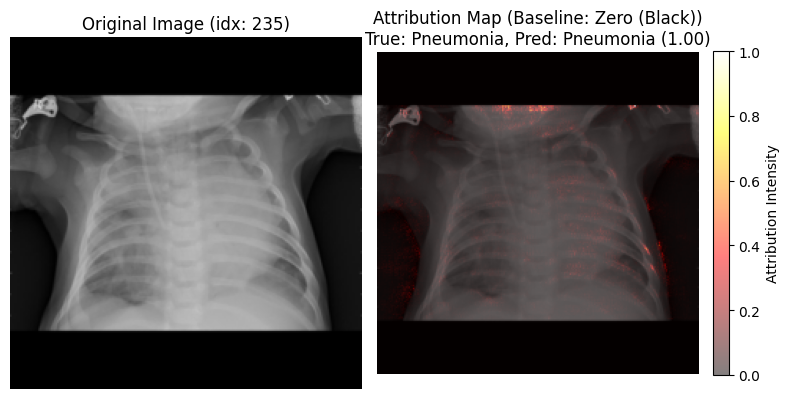

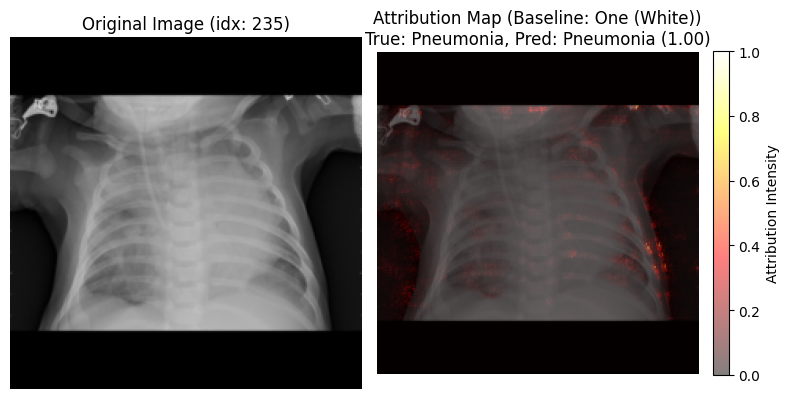

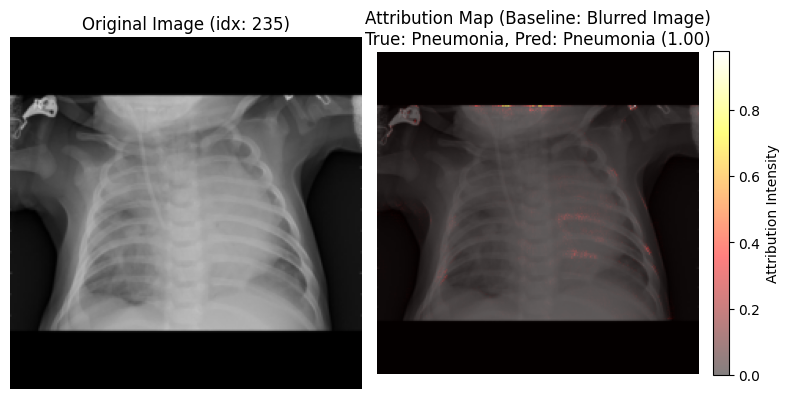

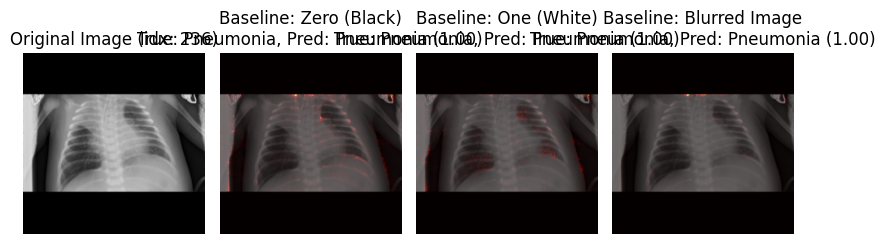

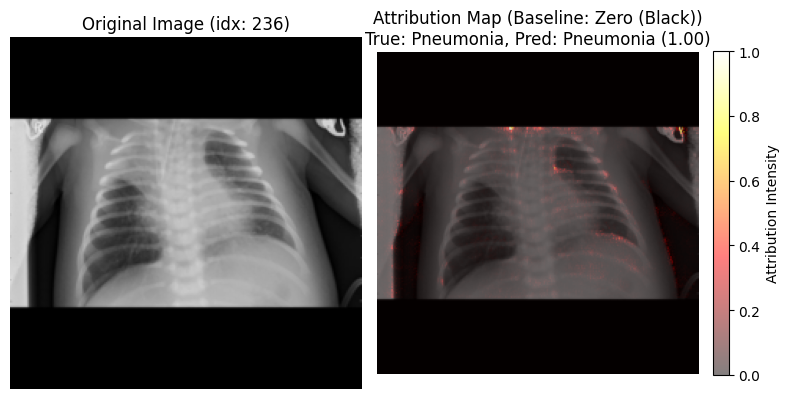

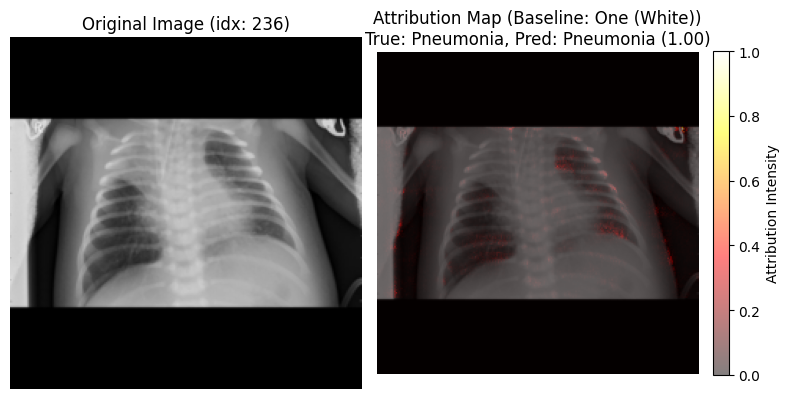

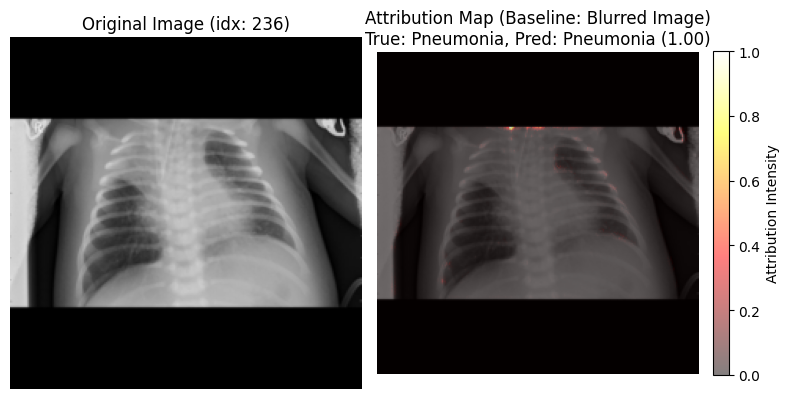

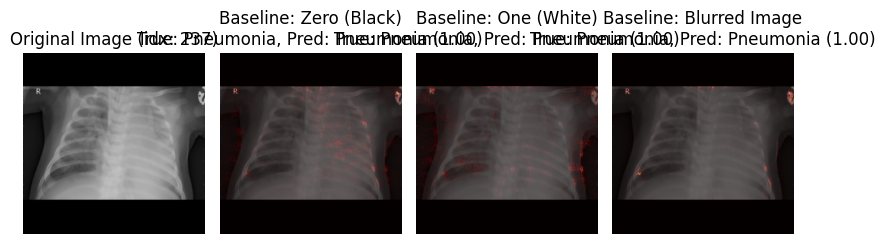

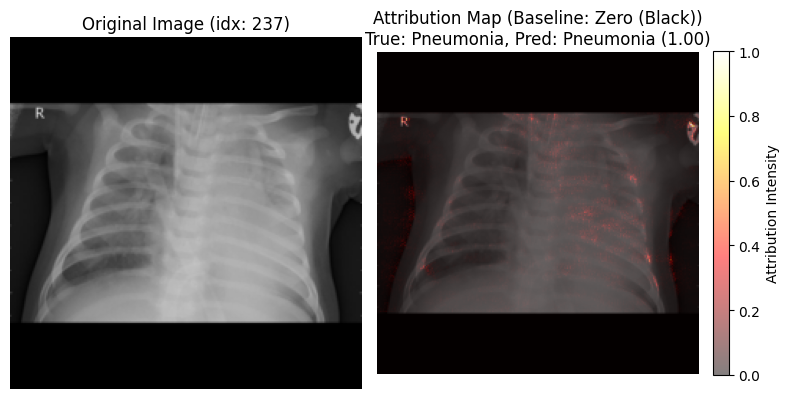

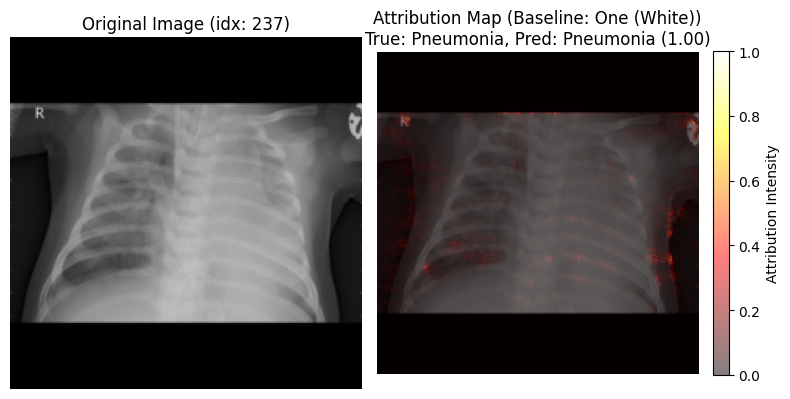

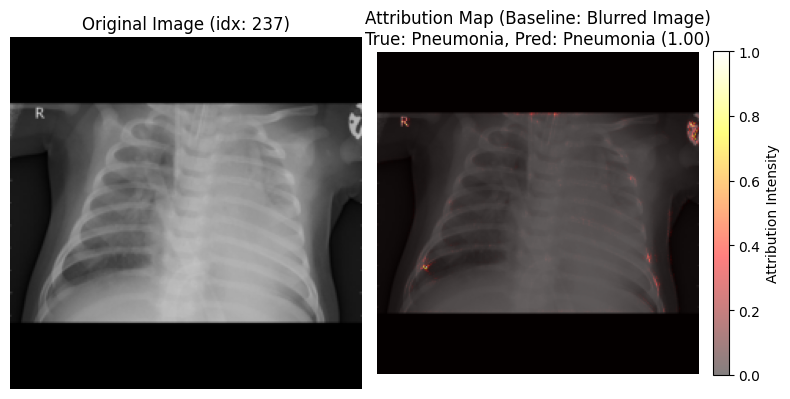

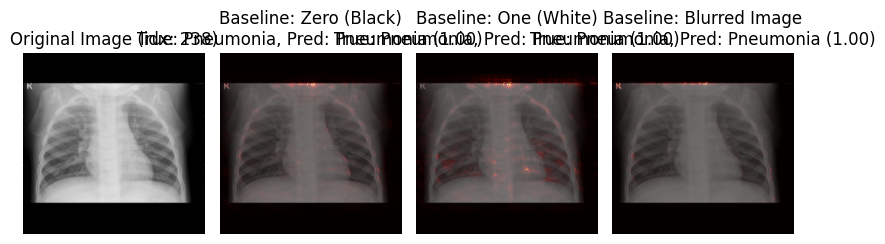

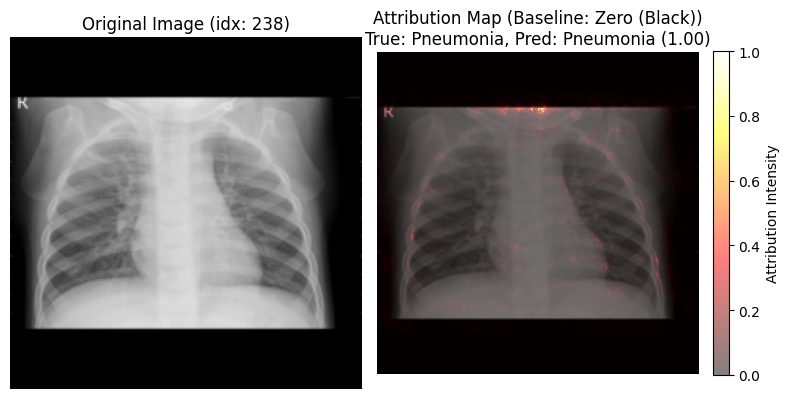

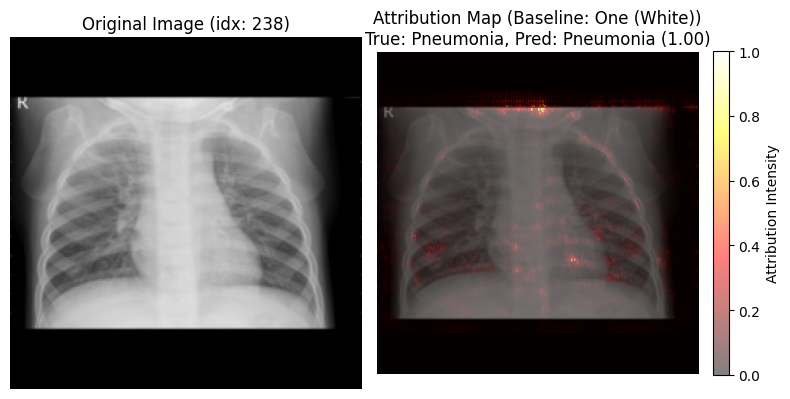

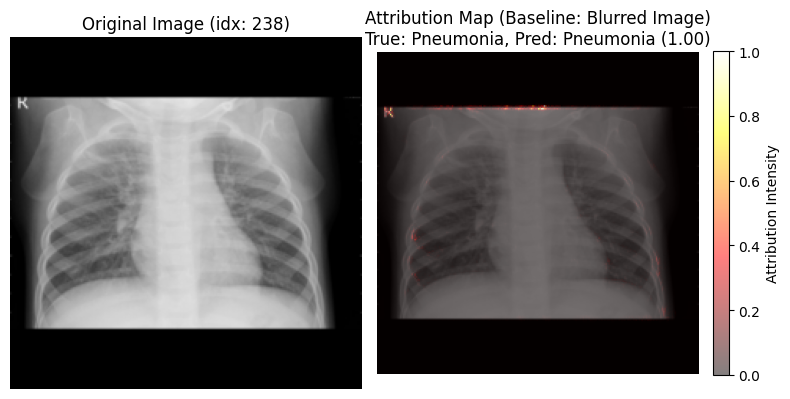

In [11]:
# Visualize the selected samples
import matplotlib.pyplot as plt
import torch
import numpy as np
from captum.attr import IntegratedGradients
from torchvision.transforms.functional import gaussian_blur
import torchvision.transforms as transforms

# Function to denormalize images for visualization
def denormalize(img):
    mean = [0.3446, 0.3446, 0.3446]
    std = [0.2830, 0.2830, 0.2830]
    img_denorm = img.clone()
    for i in range(3):
        img_denorm[i] = img_denorm[i] * std[i] + mean[i]
    return img_denorm

# Set up the figure
fig, axes = plt.subplots(4, 5, figsize=(15, 12))
fig.suptitle('Selected Samples (Normal and Pneumonia)', fontsize=16)

# Plot the samples
for i, (img, label) in enumerate(selected_samples):
    row = i // 5
    col = i % 5
    
    # Denormalize the image for visualization
    img_denorm = denormalize(img)
    
    # Convert to numpy for plotting
    img_np = img_denorm.permute(1, 2, 0).cpu().numpy()
    
    # Plot the image
    axes[row, col].imshow(img_np)
    # Add index to the title
    index = selected_indices[i]
    axes[row, col].set_title(f"{'Normal' if label.item() == 0 else 'Pneumonia'} (idx: {index})")
    axes[row, col].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.9)
plt.show()

# Load the model for integrated gradients
model.eval()

# Initialize Integrated Gradients
ig = IntegratedGradients(model)

# Define different baselines to compare
baselines = {
    "Zero (Black)": torch.zeros(1, 3, 224, 224).to(device),
    "One (White)": torch.ones(1, 3, 224, 224).to(device)
}

# Function to create a mask for the original image content (excluding padding)
def create_content_mask(original_size, target_size=224):
    original_w, original_h = original_size
    max_dim = max(original_w, original_h)
    pad_w = (max_dim - original_w) // 2
    pad_h = (max_dim - original_h) // 2
    
    # In resized space, calculate padding region
    scale = target_size / max_dim
    left = int(pad_w * scale)
    right = int((pad_w + original_w) * scale)
    top = int(pad_h * scale)
    bottom = int((pad_h + original_h) * scale)
    
    # Create a binary mask for attribution
    mask = torch.zeros((target_size, target_size))
    mask[top:bottom, left:right] = 1
    
    return mask

# Apply Integrated Gradients to each sample with different baselines
for i, (img, label) in enumerate(selected_samples):
    # Prepare input
    input_tensor = img.unsqueeze(0).to(device)
    
    # Get model prediction
    with torch.no_grad():
        output = model(input_tensor)
        pred_prob = torch.sigmoid(output).item()
        pred_class = 1 if pred_prob > 0.5 else 0
    
    # Create a blurred baseline for this specific image
    blurred = transforms.GaussianBlur(kernel_size=21)(img).unsqueeze(0).to(device) # Different levels from blurring the image, whereas 5,7  is less blurring, 15v normal , 21,31 is more
    
    # Add the blurred baseline to the baselines dictionary
    all_baselines = {**baselines, "Blurred Image": blurred}
    
    # Create a figure with multiple subplots for different baselines
    fig, axes = plt.subplots(1, len(all_baselines) + 1, figsize=(8, 4))
    
    # Denormalize the image for visualization
    img_denorm = denormalize(img)
    img_np = img_denorm.permute(1, 2, 0).cpu().numpy()
    
    # Plot the original image
    index = selected_indices[i]
    axes[0].imshow(img_np)
    axes[0].set_title(f"Original Image (idx: {index})")
    axes[0].axis('off')
    
    # Assume original size (this would need to be tracked from the original dataset)
    # For demonstration, we'll estimate it from the non-black pixels
    # In a real implementation, you would track the original size during preprocessing
    gray_img = img.mean(dim=0).cpu().numpy()
    non_zero = np.where(gray_img > 0.1)  # Threshold to find non-black pixels
    if len(non_zero[0]) > 0 and len(non_zero[1]) > 0:
        original_h = non_zero[0].max() - non_zero[0].min()
        original_w = non_zero[1].max() - non_zero[1].min()
        original_size = (original_w, original_h)
    else:
        original_size = (224, 224)  # Fallback if estimation fails
    
    # Create content mask
    content_mask = create_content_mask(original_size)
    
    # Compute attributions for each baseline
    for j, (baseline_name, baseline) in enumerate(all_baselines.items()):
        # Compute attributions using Integrated Gradients with specific baseline
        attributions = ig.attribute(input_tensor, baselines=baseline)
        
        # Apply mask to zero out attributions in padded regions
        attr_masked = attributions.squeeze().cpu() * content_mask.unsqueeze(0)
        
        # Process attributions for visualization
        attr_sum = torch.abs(attr_masked).sum(dim=0).detach().numpy()
        
        # Normalize attributions for better visualization
        attr_norm = (attr_sum - attr_sum.min()) / (attr_sum.max() - attr_sum.min() + 1e-8)
        
        # Create a heatmap overlay
        axes[j+1].imshow(img_np)
        attr_plot = axes[j+1].imshow(attr_norm, cmap='hot', alpha=0.5)
        
        # Add title with baseline information
        true_label = "Normal" if label.item() == 0 else "Pneumonia"
        pred_label = "Normal" if pred_class == 0 else "Pneumonia"
        axes[j+1].set_title(f"Baseline: {baseline_name}\nTrue: {true_label}, Pred: {pred_label} ({pred_prob:.2f})")
        axes[j+1].axis('off')
    
    plt.tight_layout()
    plt.show()
    
    # Create detailed individual plots for each baseline
    for baseline_name, baseline in all_baselines.items():
        # Compute attributions using Integrated Gradients with specific baseline
        attributions = ig.attribute(input_tensor, baselines=baseline)
        
        # Apply mask to zero out attributions in padded regions
        attr_masked = attributions.squeeze().cpu() * content_mask.unsqueeze(0)
        
        # Create a figure with two subplots side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
        
        # Plot the original image
        ax1.imshow(img_np)
        ax1.set_title(f"Original Image (idx: {index})")
        ax1.axis('off')
        
        # Process attributions for visualization
        attr_sum = torch.abs(attr_masked).sum(dim=0).detach().numpy()
        
        # Normalize attributions for better visualization
        attr_norm = (attr_sum - attr_sum.min()) / (attr_sum.max() - attr_sum.min() + 1e-8)
        
        # Create a heatmap overlay on the second subplot
        ax2.imshow(img_np)
        attr_plot = ax2.imshow(attr_norm, cmap='hot', alpha=0.5)
        
        # Add colorbar to the attribution plot
        plt.colorbar(attr_plot, ax=ax2, label='Attribution Intensity', fraction=0.046, pad=0.04)
        
        # Add title with prediction and baseline information
        true_label = "Normal" if label.item() == 0 else "Pneumonia"
        pred_label = "Normal" if pred_class == 0 else "Pneumonia"
        ax2.set_title(f"Attribution Map (Baseline: {baseline_name})\nTrue: {true_label}, Pred: {pred_label} ({pred_prob:.2f})")
        ax2.axis('off')
        
        plt.tight_layout()
        plt.show()
